# Regression Task on MNIST
We will illustrate the main components of the theory by evaluating kernel regression on handwritten digits for two different pairs of digits. First, we will attempt to discriminate between 8's and 9's and then between 0's and 1's. We expect it is easier to discriminate between 0's and 1's since 8's and 9's look more similar. Can we see why this would happen from our theory?

First, we will import some useful libraries.  

In [1]:
### If save data:
save_data = False

if save_data:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  root_dir = ''

In [2]:
!pip install -q git+https://www.github.com/google/neural-tangents
#!pip install --upgrade https://storage.googleapis.com/jax-releases/`nvcc -V | sed -En "s/.* release ([0-9]*)\.([0-9]*),.*/cuda\1\2/p"`/jaxlib-0.1.55-`python3 -V | sed -En "s/Python ([0-9]*)\.([0-9]*).*/cp\1\2/p"`-none-manylinux2010_x86_64.whl jax

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax.api import jit

import neural_tangents as nt
from neural_tangents import stax

import tensorflow_datasets as tfds
import scipy as sp
import scipy.optimize
import pandas as pd


## Define Functions to Compute Theoretical Learning Curves

In [3]:
# gets experimental E_g(p)
def get_learning_curve(pvals, K, y):
  err = np.zeros(len(pvals))
  num_repeats = 20
  for n in range(num_repeats):
    for i, p in enumerate(pvals):
      inds = np.random.randint(0,K.shape[0], int(p))
      Ki = K[inds, :]
      Kii = Ki[:,inds]
      yi = y[inds,:]
      yhat = Ki.T @ np.linalg.inv(Kii + p*1e-8*np.eye(int(p))) @ yi
      err[i] += 1/num_repeats* np.mean( (yhat - y)**2 )
  return err
  
# implicit equation for z
def implicit_fn_true(z,*args):
    (p, lamb, spectrum) = args
    return z - lamb - z * np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1))

# derivative of implicit function
def f_prime_true(z,*args):
    (p, lamb, spectrum) = args
    return 1 - np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1)) + z* np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-2))

# solve implicit equation with Newton's method
def solve_implicit_z(spectrum, pvals, lamb):
    sols = np.zeros(len(pvals))
    for i, p in enumerate(pvals):
        args = (p, p*lamb, spectrum)
        sols[i] = sp.optimize.root_scalar(implicit_fn_true, x0= p * np.amax(spectrum), args = args, fprime = f_prime_true, method = 'newton').root
    return sols

# compute theory learning curve E_g(p)
def compute_theory(pvals, spectrum, teacher, lamb):
  errs = np.zeros(len(pvals))
  zvals = solve_implicit_z(spectrum, pvals, lamb)
  for i, p in enumerate(pvals):
    zi = zvals[i]
    gamma = np.sum( spectrum**2 / (spectrum*p+zi)**2 )
    errs[i] = zi**2/(1-gamma*p) * np.sum(teacher / (spectrum*p+zi)**2 )
  return errs / len(spectrum)


## Download and Preprocess Data

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
(50000, 784)


/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


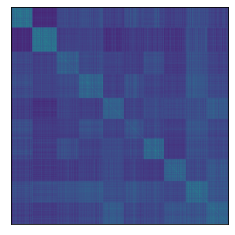

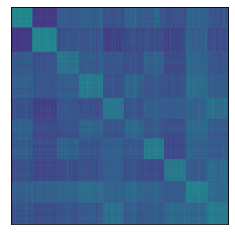

In [4]:
# Download MNIST
num_tot = 50000
dataset_name = 'MNIST'
num_classes = 10
size = 32
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  X = X / np.outer(np.linalg.norm(X, axis = 1), np.ones(X.shape[1]))
  y = ex['label'].numpy()
  y = np.eye(num_classes)[y] 
  break

print(X.shape)

# define a RELU neural tangent kernel
_,_,kernel_fn = stax.serial(stax.Dense(100), stax.Relu(), stax.Dense(1), stax.Relu(), stax.Dense(1))
kernel_fn = jit(kernel_fn, static_argnums=(2,))

inds_rand = np.random.randint(0, 50000, 5000)
sorted_inds = []
for i in range(10):
  inds_i = [j for j in inds_rand if y[j,i] == 1]
  sorted_inds += inds_i

# compute NTK and NNGP kernel matrices
K0_ntk = kernel_fn(X[sorted_inds,:],None,'ntk') 
K0_nngp = kernel_fn(X[sorted_inds,:],None,'nngp')

# plot NTK matrix visual
plt.imshow(100*K0_ntk)
plt.xticks([])
plt.yticks([])
if save_data: plt.savefig(root_dir + 'ntk_matrix_visual.pdf')
plt.show()

plt.imshow(100*K0_nngp)
plt.xticks([])
plt.yticks([])
if save_data: plt.savefig(root_dir + 'nngp_matrix_visual.pdf')
plt.show()


# Perform Eigendecomposition to get Eigenvalues and Eigenvectors of the Kernel

/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:3798: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


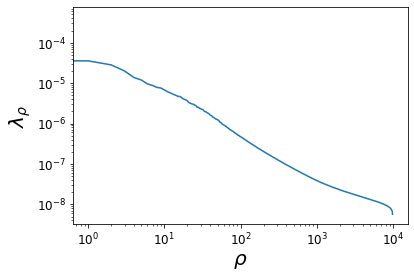

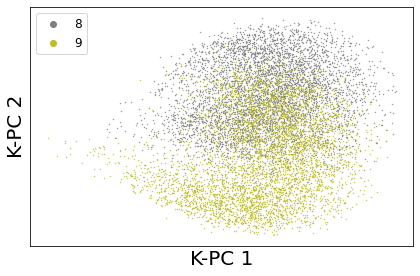

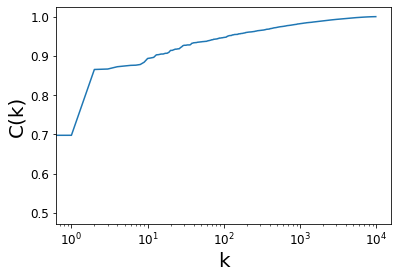

In [ ]:
# choose only 8's and 9's for a two-way regression task
# We expect this to be a difficult since 8 and 9's look similar
a = 8
b = 9
inds_89 = [i for i in range(len(y)) if y[i,a]==1 or y[i,b]==1]
y_89 = y[inds_89,:]

K_89 = kernel_fn(X[inds_89,:],None,'ntk')

# perform regression experiment
pvals = np.logspace(0,3.5,12)
lc_89 = get_learning_curve(pvals, K_89, y_89)

# perform eigendecomposition
spectrum_89, vecs_89 = jnp.linalg.eigh(1/K_89.shape[0] * K_89)
inds_sort = np.argsort(spectrum_89)
inds_sort = inds_sort[::-1]
spectrum_89 = spectrum_89[inds_sort]
vecs_89 = vecs_89[:,inds_sort]

# plot kernel eigenspectrum spectrum
plt.loglog(spectrum_89)
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\lambda_\rho$', fontsize = 20)
plt.show()

# get target spectrum 
teacher = np.mean((vecs_89.T @ y_89)**2, axis = 1)
theory_lc_89 = compute_theory(pvals, spectrum_89, teacher, 1e-8)

# 8-9 projection to kernel subspace
proj_89 = vecs_89[:,0:10].T @ K_89
if save_data:
  pd.DataFrame(proj_89).to_csv(root_dir + 'projs_%d_%d.csv' % (a,b))
  pd.DataFrame(y_89).to_csv(root_dir + 'labels_%d_%d.csv' % (a,b))

proj_89 = vecs_89[:,0:3].T @ K_89

for k,i in enumerate([a,b]):
  inds_i = [j for j in range(len(y_89)) if y_89[j,i]==1]
  plt.scatter(proj_89[0,inds_i], proj_89[1,inds_i], s=0.15, color = 'C%d' % (k+7))
  plt.scatter([],[], color = 'C%d' % (k+7), label = '%d' % i)
plt.xticks([])
plt.yticks([])
plt.xlabel('K-PC 1', fontsize=20)
plt.ylabel('K-PC 2', fontsize = 20)
plt.tight_layout()
plt.legend()
if save_data: plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_2d.pdf' % (a,b))
plt.show()

power_89 = np.sum((vecs_89.T @ y_89)**2, axis = 1)
cumul_89 = np.cumsum(power_89) / np.sum(power_89)
plt.semilogx(cumul_89)
plt.xlabel('k', fontsize = 20)
plt.ylabel('C(k)', fontsize = 20)
plt.show()

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:3798: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


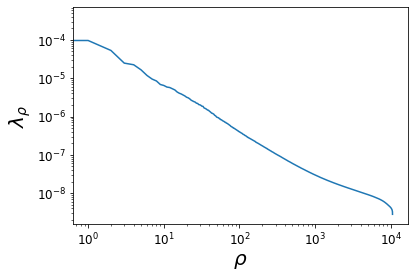

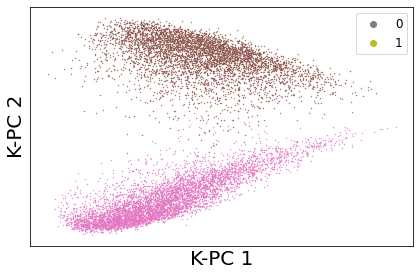

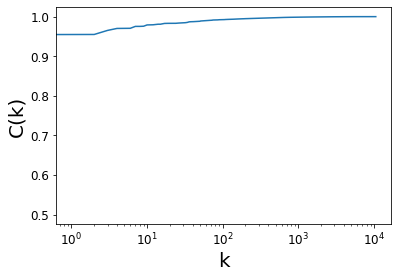

In [ ]:
# now, let's do the same with 0s and 1s
a = 0
b = 1
inds_01 = [i for i in range(len(y)) if y[i,a]==1 or y[i,b]==1]
y_01 = y[inds_01,:]

K_01 = kernel_fn(X[inds_01,:],None,'ntk')

# perform regression experiment
pvals = np.logspace(0,3.5,12)
lc_01 = get_learning_curve(pvals, K_01, y_01)

# perform eigendecomposition
spectrum_01, vecs_01 = jnp.linalg.eigh(1/K_01.shape[0] * K_01)
inds_sort = np.argsort(spectrum_01)
inds_sort = inds_sort[::-1]
spectrum_01 = spectrum_01[inds_sort]
vecs_01 = vecs_01[:,inds_sort]

# plot kernel eigenspectrum spectrum
plt.loglog(spectrum_01)
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\lambda_\rho$', fontsize = 20)
plt.show()

# get target spectrum 
teacher = np.mean((vecs_01.T @ y_01)**2, axis = 1)
theory_lc_01 = compute_theory(pvals, spectrum_01, teacher, 1e-8)

# 8-9 projection to kernel subspace
proj_01 = vecs_01[:,0:10].T @ K_01
if save_data:
  pd.DataFrame(proj_01).to_csv(root_dir + 'projs_%d_%d.csv' % (a,b))
  pd.DataFrame(y_01).to_csv(root_dir + 'labels_%d_%d.csv' % (a,b))

proj_01 = vecs_01[:,0:3].T @ K_01

for k,i in enumerate([a,b]):
  inds_i = [j for j in range(len(y_01)) if y_01[j,i]==1]
  plt.scatter(proj_01[0,inds_i], proj_01[1,inds_i], s=0.15, color = 'C%d' % (k+5))
  plt.scatter([],[], color = 'C%d' % (k+7), label = '%d' % i)
plt.xticks([])
plt.yticks([])
plt.xlabel('K-PC 1', fontsize=20)
plt.ylabel('K-PC 2', fontsize = 20)
plt.tight_layout()
plt.legend()
if save_data: plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_2d.pdf' % (a,b))
plt.show()

power_01 = np.sum((vecs_01.T @ y_01)**2, axis = 1)
cumul_01 = np.cumsum(power_01) / np.sum(power_01)
plt.semilogx(cumul_01)
plt.xlabel('k', fontsize = 20)
plt.ylabel('C(k)', fontsize = 20)
plt.show()

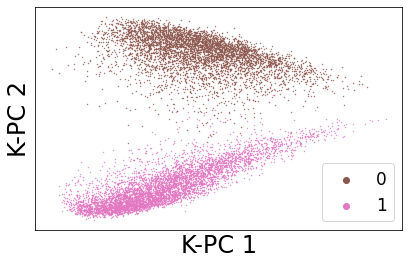

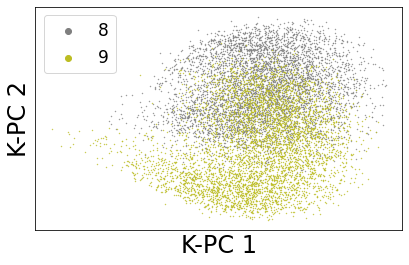

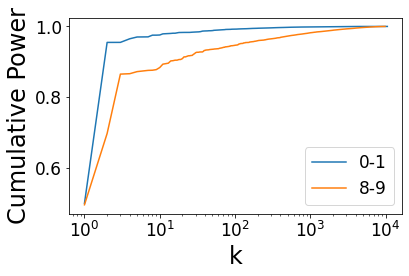

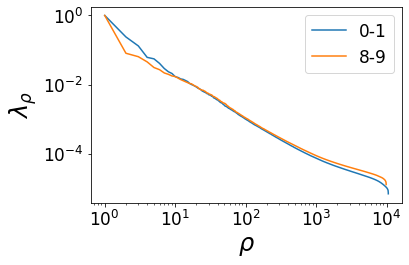

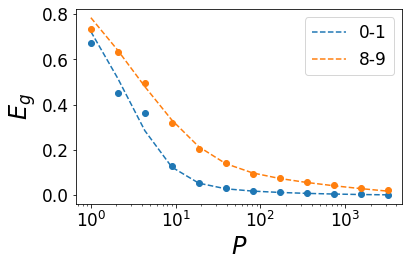

In [ ]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(6,4))
for k,i in enumerate([0,1]):
  inds_i = [j for j in range(len(y_01)) if y_01[j,i]==1]
  plt.scatter(proj_01[0,inds_i], proj_01[1,inds_i], s=0.15, color = 'C%d' % (k+5))
  plt.scatter([],[], color = 'C%d' % (k+5), label = '%d' % i)
plt.xticks([])
plt.yticks([])
plt.xlabel('K-PC 1', fontsize=24)
plt.ylabel('K-PC 2', fontsize = 24)
plt.tight_layout()
plt.legend()
if save_data: plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_2d.pdf' % (0,1))
plt.show()

plt.figure(figsize=(6,4))
for k,i in enumerate([8,9]):
  inds_i = [j for j in range(len(y_89)) if y_89[j,i]==1]
  plt.scatter(proj_89[0,inds_i], proj_89[1,inds_i], s=0.15, color = 'C%d' % (k+7))
  plt.scatter([],[], color = 'C%d' % (k+7), label = '%d' % i)
plt.xticks([])
plt.yticks([])
plt.xlabel('K-PC 1', fontsize=24)
plt.ylabel('K-PC 2', fontsize = 24)
plt.tight_layout()
plt.legend()
if save_data: plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_2d.pdf' % (8,9))
plt.show()

plt.figure(figsize=(6,4))
plt.semilogx(np.linspace(1,len(cumul_01),len(cumul_01)), cumul_01, label = '0-1')
plt.semilogx(np.linspace(1,len(cumul_89),len(cumul_89)), cumul_89, label = '8-9')
plt.xlabel('k', fontsize = 24)
plt.ylabel('Cumulative Power', fontsize =24)
plt.legend()
plt.tight_layout()
if save_data: plt.savefig(root_dir + 'cumulative_power_kpc.pdf')
plt.show()

plt.figure(figsize=(6,4))
plt.loglog(np.linspace(1,len(cumul_01),len(cumul_01)), spectrum_01/spectrum_01[0], label = '0-1')
plt.loglog(np.linspace(1,len(cumul_89),len(cumul_89)), spectrum_89/spectrum_89[0], label = '8-9')
plt.xlabel(r'$\rho$', fontsize = 24)
plt.ylabel(r'$\lambda_\rho$', fontsize =24)
plt.legend()
plt.tight_layout()
if save_data: plt.savefig(root_dir + 'spectrum_kpc.pdf')
plt.show()

plt.figure(figsize=(6,4))
plt.semilogx(pvals, 10*lc_01, 'o', color = 'C0')
plt.semilogx(pvals, 10*theory_lc_01, '--', color ='C0', label = '0-1')
plt.semilogx(pvals, 10*lc_89, 'o', color = 'C1')
plt.semilogx(pvals, 10*theory_lc_89, '--', color ='C1', label = '8-9')
plt.xlabel(r'$P$', fontsize = 24)
plt.ylabel(r'$E_g$', fontsize = 24)
plt.legend()
plt.tight_layout()
if save_data: plt.savefig(root_dir + 'binary_learning_curves.pdf')
plt.show()

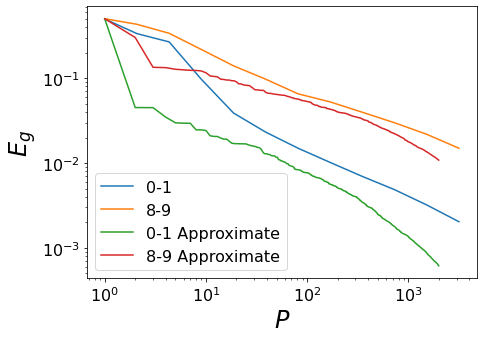

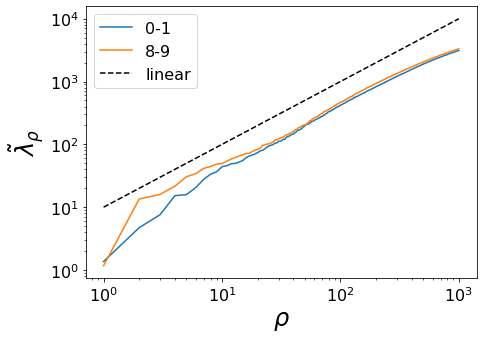

In [ ]:
pmax_approx = int(10**(3.3))

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(7,5))

plt.loglog(pvals, lc_01 / lc_01[0] * (1-cumul_01[0]), label = '0-1')
plt.loglog(pvals, lc_89 / lc_89[0] * (1-cumul_89[0]), label = '8-9')
plt.loglog(np.linspace(1,pmax_approx, pmax_approx), 1-cumul_01[0:pmax_approx], label = '0-1 Approximate')
plt.loglog(np.linspace(1,pmax_approx, pmax_approx), 1-cumul_89[0:pmax_approx], label = '8-9 Approximate')
plt.xlabel(r'$P$', fontsize =24)
plt.ylabel(r'$E_g$', fontsize=24)
plt.legend()
plt.tight_layout()
if save_data: plt.savefig(root_dir + 'approximate_learning_curve.pdf')
plt.show()



# plot effective regularization vs rho
tail_sums_01 = (np.sum(spectrum_01) - np.cumsum(spectrum_01))/spectrum_01
tail_sums_89 = (np.sum(spectrum_89) - np.cumsum(spectrum_89))/spectrum_89

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 16})
plt.loglog(np.linspace(1,1000,1000),tail_sums_01[0:1000], label = '0-1')
plt.loglog(np.linspace(1,1000,1000),tail_sums_89[0:1000], label = '8-9')
plt.loglog(np.linspace(1,1000,1000), 10*np.linspace(1,1000,1000), '--', color = 'black', label = 'linear')
plt.xlabel(r'$\rho$', fontsize =24)
plt.ylabel(r'$\tilde \lambda_\rho$', fontsize=24)
plt.legend()
plt.tight_layout()
if save_data: plt.savefig(root_dir+'effective_regularization.pdf')
plt.show()

# Conclusion

We see that the theory curves (shown in dashed lines) agree very well with the experimental errors, especially at large $p$ where the saddle point approximation is valid. Further, the 0-1 task, which possesses a quickly rising cumulative power distribution $C(k)$ has lower test error for each $p$ than the 8-9 task which has a slowly rising $C(k)$.  

This theory is not meant to be a replacement for cross-validation: in practice generalization is always determined with held out test data. However, the development of this theory provides tools for understanding when and why a chosen kernel will generalize when trained on samples from a certain data distribution. 

Future work could explore architecture of neural tangent kernels (convolutions, pooling, etc) and their impact on sample efficiency for image datasets. In addition, some lines of work have suggested that neural networks in the feature learning regime [compress irrelevant dimensions](https://arxiv.org/abs/2007.11471) and that kernel methods/lazy neural networks perform equally well on compressed datasets. It would be interesting to continue this line of work with the insights of our theory by exploring anisotropic distributions $p(x)$. 